In [4]:
from datasets import load_dataset, get_dataset_config_names, get_dataset_split_names
import duckdb, pandas as pd, pathlib, gc
from datasets import load_dataset
import numpy as np
from cleantext import clean
import os, nltk
import os, nltk, re
from bs4 import BeautifulSoup
import hashlib

pd.set_option("display.max_colwidth", None)

DB_PATH = '../data/duckdb/subs.duckdb'
TABLE   = 'ptbrvarid'   # raw goes here, as you requested
BATCH   = 20_000
NLTK_USER_DIR = os.path.expanduser("~/nltk_data")
nltk.download("punkt", quiet=True)
NLTK_USER_DIR = os.path.expanduser("~/nltk_data")
if NLTK_USER_DIR not in nltk.data.path:
    nltk.data.path.append(NLTK_USER_DIR)

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [ ]:
from datasets import load_dataset, get_dataset_config_names, get_dataset_split_names
import duckdb, pandas as pd, pathlib, gc

DB_PATH = '../data/duckdb/subs.duckdb'
TABLE   = 'ptbrvarid'   # raw goes here, as you requested
BATCH   = 20_000

with duckdb.connect(DB_PATH) as con:
    con.execute("""
    CREATE TABLE IF NOT EXISTS ptbrvarid (
        dataset     TEXT,
        domain      TEXT,
        split       TEXT,
        label       TEXT,           -- 'pt-BR' | 'pt-PT'
        text_pt_br  TEXT,
        text_pt_pt  TEXT
    );
    """)
    # keep only RAW rows scoped by dataset tag so we can also store processed later
    con.execute("DELETE FROM ptbrvarid WHERE dataset='PtBrVId-Raw'")

def ingest_ptbrvid_raw():
    with duckdb.connect(DB_PATH) as con:
        for domain in get_dataset_config_names('liaad/PtBrVId-Raw'):
            print(f"Processing domain: {domain}")
            for split in get_dataset_split_names('liaad/PtBrVId-Raw', domain):
                print(f"  Processing split: {split}")
                ds  = load_dataset('liaad/PtBrVId-Raw', domain, split=split, streaming=True)
                buf = []; n_in = n_new = 0
                for ex in ds:
                    lbl = 'pt-BR' if ex['label'] == 1 else 'pt-PT'
                    br  = ex['text'] if lbl == 'pt-BR' else None
                    pt  = ex['text'] if lbl == 'pt-PT' else None
                    buf.append(('PtBrVId-Raw', domain, split, lbl, br, pt))
                    n_in += 1
                    if len(buf) >= BATCH:
                        df = pd.DataFrame(buf, columns=['dataset','domain','split','label','text_pt_br','text_pt_pt'])
                        con.register('buf', df)
                        con.execute("INSERT INTO ptbrvarid SELECT * FROM buf")
                        con.unregister('buf'); n_new += len(buf); buf.clear(); gc.collect()
                if buf:
                    df = pd.DataFrame(buf, columns=['dataset','domain','split','label','text_pt_br','text_pt_pt'])
                    con.register('buf', df)
                    con.execute("INSERT INTO ptbrvarid SELECT * FROM buf")
                    con.unregister('buf'); n_new += len(buf); buf.clear(); gc.collect()
                print(f"✓ {domain}/{split}: read {n_in:,}, wrote {n_new:,}")

ingest_ptbrvid_raw()


Processing domain: journalistic
  Processing split: train


KeyboardInterrupt: 

In [ ]:
def ensure_punkt():
    """
    Ensure Portuguese punkt is available and visible to this kernel.
    Newer NLTK may also require 'punkt_tab'.
    """
    try:
        nltk.data.find("tokenizers/punkt/portuguese.pickle")
    except LookupError:
        # download into the same directory we added to nltk.data.path
        nltk.download("punkt", download_dir=NLTK_USER_DIR, quiet=True)
        try:
            nltk.data.find("tokenizers/punkt/portuguese.pickle")
        except LookupError:
            nltk.download("punkt_tab", download_dir=NLTK_USER_DIR, quiet=True)
            nltk.data.find("tokenizers/punkt/portuguese.pickle")

# ----------------------------
# Author's regex & helpers (verbatim)
# ----------------------------
import re
from bs4 import BeautifulSoup
import hashlib

HTML_RE = re.compile(r"<[^>]+>")
URL_RE = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#…])*")
HASHTAG_RE = re.compile(r"#(\w+)")
QUOTE_SPACE_START_RE = re.compile(r"^\"\s")
QUOTE_SPACE_END_RE = re.compile(r"\s\"$")
MENTION_RE = re.compile(r"@(\w+)")
RETWEET_RE = re.compile(r"RT @(\w+):")
COD_RE = re.compile(r"COD _ (\w+) ")
BULLET_RE = re.compile(r"^(\d)+.\s")
THREE_DASH_RE = re.compile(r"---.*---")
MORE_THAN_THREE_POINTS_RE = re.compile(r"\.{4,}")
MODE = "ptbrvarid"   # options: "ptbrvarid" | "ptradutor"


VALID_CHARS = "0123456789abcdefghijklmnopqrstuvwxyzàáâãåāèéêëěėēîïíìįīĵłñńôöòóōõšśûüùúūÿýźçćčñń!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~«»“”ºª€ \t\n\r\x0b\x0c"

INVALID_START = [
    "List of recent changes","Sort by","Home |","> Home","useful tips","Licenses:","Search in: ",
    "Terms of Use - ","Home page","Home Page","Copyright","Results/Page",
    "!","#","$","%","&","*","+",
    ",","-",".","/",":",";","<","=",
    ">","?","@","[","\\","]","^","_","`","{","|","}","~",
]
INVALID_MIDDLE = [" @ ", " / ", " | ", "[...]", "(...)"]
INVALID_END = [" ("]

MONTHS = ["january","february","march","april","may","june","july","august","september","october","november","december"]
SPEAKER_LABEL_SINGLE_LETTER = re.compile(
    r'(?m)(^|\s|[(\["“])'          # \1 = boundary we preserve
    r'[A-Za-zÀ-ÖØ-öø-ÿ]\.'         # exactly one letter + dot
    r'\s*(?:--|[-–—]{1,2})\s*'     # "--" or one/two dashes (hyphen/en/em), with spaces
)

# Word followed by double hyphen (speaker label), preserving the boundary before it
SPEAKER_LABEL_WORD_DASH = re.compile(
    r'(?m)(^|\s)[A-Za-zÀ-ÖØ-öø-ÿ]+(?:\.)?\s+--\s*'
)

# Dialogue-leading double dash right after strong punctuation or line start
DIALOGUE_LEADING_DASH = re.compile(
    r'(?m)(^|[\.!\?\:\;…])\s*--\s*'
)

# Capitalize the first letter after strong punctuation or at start of text/line.
# Keeps any opening quotes/brackets just before the letter.
CAP_SENT_START = re.compile(
    r'(?m)(^|[\.!\?\:\;…]\s+)([\"\'“”«»\(\[\{]*)([a-zà-öø-ÿ])'
)


def remove_html_tags(text): return BeautifulSoup(text, "html.parser").get_text()
def remove_hashtags(text): return HASHTAG_RE.sub("", text).strip()
def remove_mentions(text): return MENTION_RE.sub("", text).strip()
def remove_retweets(text): return RETWEET_RE.sub("", text).strip()
def remove_urls(text): return URL_RE.sub("", text).strip()
def remove_cod_literature(text): return COD_RE.sub("", text).strip()
def remove_bullets(text): return BULLET_RE.sub("", text).strip()
def remove_three_dashes(text): return THREE_DASH_RE.sub("", text).strip()
def remove_quote_space_start(text): return QUOTE_SPACE_START_RE.sub('"', text)
def remove_quote_space_end(text):
    if text.endswith(' "'): return text[:-2] + '"'
    return text
def has_more_than_three_points(text): return bool(MORE_THAN_THREE_POINTS_RE.search(text))
def starts_with_month(text): return text.lower().startswith(tuple(MONTHS))
def has_too_long_word(text): return any(word for word in text.split(" ") if len(word) > 20)
def has_invalid_start(text): return text.startswith(tuple(INVALID_START))
def has_invalid_middle(text): return any(True for word in INVALID_MIDDLE if word in text)
def has_invalid_end(text): return text.endswith(tuple(INVALID_END))
def has_valid_brackets(text): return (text.count("(")==text.count(")") and text.count("[")==text.count("]") and text.count("{")==text.count("}"))
def has_valid_quotes(text): return text.count('"') % 2 == 0 and text.count("“")==text.count("”")
def is_empty(text): return len(text) == 0
def has_invalid_character(text):
    for char in text:
        if char.lower() not in VALID_CHARS: return True
    return False

def normalize_double_quotes(text: str) -> str:
    if not text: return text
    return (text.replace("«", '"').replace("»", '"')
                .replace("“", '"').replace("”", '"')
                .replace("„", '"'))

def remove_single_letter_speaker_labels(text: str) -> str:
    if not text: return text
    return SPEAKER_LABEL_SINGLE_LETTER.sub(r"\1", text)

def remove_speaker_label_word_dash(text: str) -> str:
    if not text: return text
    return SPEAKER_LABEL_WORD_DASH.sub(r'\1', text)

def remove_dialogue_leading_double_dash(text: str) -> str:
    if not text: return text
    return DIALOGUE_LEADING_DASH.sub(lambda m: (m.group(1) or '') + ' ', text)

def capitalize_sentence_starts(text: str) -> str:
    if not text: return text
    m = re.match(r'^([\"\'“”«»\(\[\{]*)([a-zà-öø-ÿ])', text)
    if m: text = m.group(1) + m.group(2).upper() + text[m.end():]
    def repl(m): return (m.group(1) or '') + (m.group(2) or '') + m.group(3).upper()
    return CAP_SENT_START.sub(repl, text)

def author_transform_chain(text: str) -> str:
    text = remove_retweets(text); text = remove_mentions(text); text = remove_hashtags(text)
    text = remove_urls(text); text = remove_html_tags(text); text = normalize_double_quotes(text)
    text = remove_single_letter_speaker_labels(text); text = remove_speaker_label_word_dash(text)
    text = remove_dialogue_leading_double_dash(text); text = remove_cod_literature(text)
    text = remove_bullets(text); text = remove_three_dashes(text)
    text = remove_quote_space_start(text); text = remove_quote_space_end(text)
    text = re.sub(r'\s{2,}', ' ', text).strip()
    text = capitalize_sentence_starts(text)
    return text

def drop_nans_and_empties(ds):
    return ds.filter(lambda x: x["text"] is not None and len(x["text"].strip()) > 0)

def drop_exact_duplicates(ds, batch_size: int = 1000):
    seen = set()
    def tag_batch(batch):
        keep = []
        for t in batch["text"]:
            h = hashlib.md5(t.encode("utf-8")).hexdigest()
            keep.append(h not in seen)
            seen.add(h)
        return {"__keep__": keep}
    ds = ds.map(tag_batch, batched=True, batch_size=batch_size, num_proc=1)
    ds = ds.filter(lambda k: k, input_columns="__keep__").remove_columns(["__keep__"])
    return ds

def apply_clean_text_ascii(s: str) -> str:
    return clean(s, fix_unicode=True, to_ascii=True, lower=False,
                 no_line_breaks=False, no_urls=False, no_emails=False,
                 no_phone_numbers=False, no_numbers=False, no_digits=False, no_currency_symbols=False)

_FALLBACK_TOKEN_RE = re.compile(r"\w+|[^\w\s]")
def pt_word_count(s: str) -> int:
    try:
        return len(nltk.word_tokenize(s, language="portuguese"))
    except LookupError:
        return len(_FALLBACK_TOKEN_RE.findall(s))

def add_length_column(ds, batch_size: int = 1000):
    def _lens(batch): return {"__len__": [pt_word_count(t) for t in batch["text"]]}
    return ds.map(_lens, batched=True, batch_size=batch_size, num_proc=1)

def iqr_bounds_from_lengths(lengths):
    q1, q3 = np.percentile(lengths, 25), np.percentile(lengths, 75)
    iqr = q3 - q1
    return (q1 - 1.5*iqr, q3 + 1.5*iqr)

def apply_iqr_filter_on_cached_lengths(ds, lo, hi):
    ds = ds.filter(lambda L: lo <= L <= hi, input_columns="__len__")
    return ds.remove_columns(["__len__"])

def apply_clean_text_unicode_only(s: str) -> str:
    return clean(s, fix_unicode=True, to_ascii=False, lower=False,
                 no_line_breaks=False, no_urls=False, no_emails=False,
                 no_phone_numbers=False, no_numbers=False, no_digits=False, no_currency_symbols=False)

# ====== NEW: safe jusText wrapper + scope switch ======
def safe_justext(text: str) -> str:
    if not text: return text
    try:
        import justext
        paras = justext.justext(text, justext.get_stoplist("Portuguese"))
        good = [p.text for p in paras if p.class_type == "good"]
        return "\n".join(good) if good else text
    except Exception:
        return text

def clean_one_domain_split(
    domain: str,
    split: str,
    use_author_transforms: bool = True,
    run_web_justext: bool = True,   # kept for back-compat (ignored if justext_scope is set)
    apply_author_filters: bool = True,
    keep_accents: bool = True,
    num_proc: int = 1,
    batch_size: int = 1000,
    *,
    justext_scope: str = "web",     # NEW: "none" | "web" | "all"
):
    """
    Same as yours, but jusText can run on: none / web / all.
    """
    ds = load_dataset("liaad/PtBrVId-Raw", domain, split=split)
    ds = drop_nans_and_empties(ds)

    # --- jusText control (NEW) ---
    scope = justext_scope or ("web" if run_web_justext else "none")
    if scope == "all" or (scope == "web" and domain == "web"):
        ds = ds.map(lambda x: {"text": web_justext(x["text"])},
                    num_proc=num_proc, batched=False)

    # (rest of your function unchanged below…)
    if use_author_transforms:
        ds = ds.map(lambda x: {"text": author_transform_chain(x["text"])},
                    num_proc=num_proc, batched=False)

    if keep_accents:
        ds = ds.map(lambda x: {"text": apply_clean_text_unicode_only(x["text"])},
                    num_proc=num_proc, batched=False)
    else:
        ds = ds.map(lambda x: {"text": apply_clean_text_ascii(x["text"])},
                    num_proc=num_proc, batched=False)

    ds = drop_exact_duplicates(ds, batch_size=batch_size)

    if apply_author_filters:
        ds = ds.filter(
            lambda t: (not starts_with_month(t))
                      and (not has_too_long_word(t))
                      and (not has_invalid_start(t))
                      and (not has_invalid_middle(t))
                      and (not has_invalid_end(t))
                      and (not has_more_than_three_points(t))
                      and (not is_empty(t))
                      and (not has_invalid_character(t))
                      and has_valid_brackets(t)
                      and has_valid_quotes(t),
            input_columns="text",
            num_proc=num_proc
        )

    ds = add_length_column(ds, batch_size=batch_size)
    lo, hi = iqr_bounds_from_lengths(ds["__len__"])
    ds = apply_iqr_filter_on_cached_lengths(ds, lo, hi)
    return ds



In [ ]:
# =============================
# STEP 2 + METRICS (single pass per domain/split with on-disk staging)
# - Applies jusText on ALL domains (and really drops boilerplate)
# - Writes final rows into ptbrvarid (dataset='PtBrVId')
# - Writes per-stage counts into ptbrvarid_metrics
# =============================
from datasets import load_dataset, get_dataset_config_names, get_dataset_split_names
import duckdb, pandas as pd, numpy as np, hashlib, warnings, re
from bs4 import MarkupResemblesLocatorWarning
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

DB_PATH = "../data/duckdb/subs.duckdb"
BATCH_ROWS = 20_000

# -------- jusText that actually prunes --------
def web_justext(text: str,
                *,
                drop_if_no_good: bool = True,
                min_chars: int = 30,
                min_ratio: float = 0.20) -> str:
    """
    Run jusText and drop rows that look like boilerplate.
    - drop_if_no_good: drop if no 'good' paragraphs
    - min_chars: drop if cleaned text shorter than this
    - min_ratio: drop if cleaned/original length ratio below this
    """
    if not text:
        return ""
    try:
        import justext
        paras = justext.justext(text, justext.get_stoplist("Portuguese"))
        good  = [p.text for p in paras if p.class_type == "good"]
        if not good:
            return "" if drop_if_no_good else text
        jt = "\n".join(good).strip()
        if len(jt) < min_chars:
            return ""
        if len(jt) / max(1, len(text)) < min_ratio:
            return ""
        return jt
    except Exception:
        return text  # conservative on parser error

# -------- tiny helper: your heuristic predicate --------
def _pass_filters(t: str) -> bool:
    return (not starts_with_month(t)
            and not has_too_long_word(t)
            and not has_invalid_start(t)
            and not has_invalid_middle(t)
            and not has_invalid_end(t)
            and not has_more_than_three_points(t)
            and not is_empty(t)
            and not has_invalid_character(t)
            and has_valid_brackets(t)
            and has_valid_quotes(t))

# -------- DB setup --------
with duckdb.connect(DB_PATH) as con:
    con.execute("""
        CREATE TABLE IF NOT EXISTS ptbrvarid (
            dataset     TEXT,
            domain      TEXT,
            split       TEXT,
            label       TEXT,
            text_pt_br  TEXT,
            text_pt_pt  TEXT
        )
    """)
    con.execute("""
        CREATE TABLE IF NOT EXISTS ptbrvarid_metrics (
            dataset     TEXT,
            domain      TEXT,
            split       TEXT,
            raw                 BIGINT,
            after_nonempty      BIGINT,
            after_jusText       BIGINT,
            after_author        BIGINT,
            after_clean         BIGINT,
            after_dedup         BIGINT,
            after_filters       BIGINT,
            after_IQR           BIGINT,
            drop_empty          BIGINT,
            drop_jusText        BIGINT,
            drop_author         BIGINT,
            drop_clean          BIGINT,
            drop_dedup          BIGINT,
            drop_filters        BIGINT,
            drop_IQR            BIGINT,
            IQR_lo              DOUBLE,
            IQR_hi              DOUBLE
        )
    """)
    # Clear previous processed rows + metrics for a clean rebuild
    con.execute("DELETE FROM ptbrvarid WHERE dataset='PtBrVId'")
    con.execute("DELETE FROM ptbrvarid_metrics WHERE dataset='PtBrVId'")

def _safe_tbl(name: str) -> str:
    return re.sub(r"[^A-Za-z0-9_]", "_", name)

def process_domain_split(domain: str, split: str,
                         *, keep_accents: bool = True,
                         use_author_transforms: bool = True,
                         apply_author_filters: bool = True) -> None:
    """
    Single (domain, split) processing:
      Pass 1: stream RAW -> jusText -> author -> clean (accents kept) -> de-dup -> filters
              write (label, cleaned_text, len_tokens) to stage table on disk
              collect per-stage counters
      Compute IQR from stage lengths
      Insert survivors into ptbrvarid
      Save metrics, drop stage table
    """
    stage = f"__ptbr_stage_{_safe_tbl(domain)}_{_safe_tbl(split)}"
    with duckdb.connect(DB_PATH) as con:
        con.execute(f"DROP TABLE IF EXISTS {stage}")
        con.execute(f"""
            CREATE TABLE {stage} (
                domain TEXT,
                split  TEXT,
                label  TEXT,
                text   TEXT,
                len_tokens BIGINT
            )
        """)

    raw_n = n_nonempty = n_after_jt = n_after_author = n_after_clean = n_after_dedup = n_after_filters = 0
    seen, buf = set(), []

    # ---------- PASS 1: build stage ----------
    ds = load_dataset("liaad/PtBrVId-Raw", domain, split=split, streaming=True)
    for ex in ds:
        raw_n += 1
        t = (ex["text"] or "").strip()
        if not t:
            continue
        n_nonempty += 1

        # jusText on ALL domains; now actually drops boilerplate
        t = web_justext(t)
        if not t:
            continue
        n_after_jt += 1

        if use_author_transforms:
            t = author_transform_chain(t)
            if not t:
                continue
        n_after_author += 1

        t = apply_clean_text_unicode_only(t) if keep_accents else apply_clean_text_ascii(t)
        t = (t or "").strip()
        if not t:
            continue
        n_after_clean += 1

        h = hashlib.md5(t.encode("utf-8")).hexdigest()
        if h in seen:
            continue
        seen.add(h)
        n_after_dedup += 1

        if apply_author_filters and (not _pass_filters(t)):
            continue
        n_after_filters += 1

        L = pt_word_count(t)
        lbl = 'pt-BR' if ex['label'] == 1 else 'pt-PT'
        buf.append((domain, split, lbl, t, int(L)))

        if len(buf) >= BATCH_ROWS:
            with duckdb.connect(DB_PATH) as con:
                con.executemany(f"INSERT INTO {stage} VALUES (?,?,?,?,?)", buf)
            buf.clear()
    if buf:
        with duckdb.connect(DB_PATH) as con:
            con.executemany(f"INSERT INTO {stage} VALUES (?,?,?,?,?)", buf)
        buf.clear()

    # If nothing survived pre-IQR, write metrics and return
    with duckdb.connect(DB_PATH) as con:
        n_stage = con.execute(f"SELECT COUNT(*) FROM {stage}").fetchone()[0]
        if n_stage == 0:
            metrics_row = ('PtBrVId', domain, split,
                           raw_n, n_nonempty, n_after_jt, n_after_author, n_after_clean,
                           n_after_dedup, n_after_filters, 0,
                           raw_n-n_nonempty, n_nonempty-n_after_jt, n_after_jt-n_after_author,
                           n_after_author-n_after_clean, n_after_clean-n_after_dedup,
                           n_after_dedup-n_after_filters, n_after_filters-0,
                           0.0, 0.0)
            con.execute("""
                INSERT INTO ptbrvarid_metrics (
                    dataset, domain, split,
                    raw, after_nonempty, after_jusText, after_author, after_clean,
                    after_dedup, after_filters, after_IQR,
                    drop_empty, drop_jusText, drop_author, drop_clean, drop_dedup, drop_filters, drop_IQR,
                    IQR_lo, IQR_hi
                ) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
            """, metrics_row)
            con.execute(f"DROP TABLE {stage}")
            print(f"{domain}/{split}: raw={raw_n:,} → after_IQR=0 (0.0%)")
            return

        # Compute IQR bounds on lengths
        q1, q3 = con.execute(
            f"SELECT quantile_cont(len_tokens,0.25), quantile_cont(len_tokens,0.75) FROM {stage}"
        ).fetchone()
        iqr = q3 - q1
        lo = float(q1 - 1.5 * iqr)
        hi = float(q3 + 1.5 * iqr)

        # Survivors count
        n_after_iqr = con.execute(
            f"SELECT COUNT(*) FROM {stage} WHERE len_tokens BETWEEN ? AND ?", [lo, hi]
        ).fetchone()[0]

        # Insert final rows into ptbrvarid
        con.execute(f"""
            INSERT INTO ptbrvarid
            SELECT
              'PtBrVId' AS dataset,
              domain, split, label,
              CASE WHEN label='pt-BR' THEN text ELSE NULL END AS text_pt_br,
              CASE WHEN label='pt-PT' THEN text ELSE NULL END AS text_pt_pt
            FROM {stage}
            WHERE len_tokens BETWEEN ? AND ?
        """, [lo, hi])

        # Metrics row (FIXED: 20 placeholders + explicit columns)
        metrics_row = ('PtBrVId', domain, split,
                       raw_n, n_nonempty, n_after_jt, n_after_author, n_after_clean,
                       n_after_dedup, n_after_filters, int(n_after_iqr),
                       raw_n-n_nonempty, n_nonempty-n_after_jt, n_after_jt-n_after_author,
                       n_after_author-n_after_clean, n_after_clean-n_after_dedup,
                       n_after_dedup-n_after_filters, n_after_filters-int(n_after_iqr),
                       lo, hi)
        con.execute("""
            INSERT INTO ptbrvarid_metrics (
                dataset, domain, split,
                raw, after_nonempty, after_jusText, after_author, after_clean,
                after_dedup, after_filters, after_IQR,
                drop_empty, drop_jusText, drop_author, drop_clean, drop_dedup, drop_filters, drop_IQR,
                IQR_lo, IQR_hi
            ) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
        """, metrics_row)

        # Drop stage
        con.execute(f"DROP TABLE {stage}")

        pct = round(100.0 * (n_after_iqr / max(1, raw_n)), 2)
        print(f"{domain}/{split}: raw={raw_n:,} → after_IQR={n_after_iqr:,} ({pct}%)")


# -------- Run all (domains/splits discovered from -Raw) --------
domains = get_dataset_config_names("liaad/PtBrVId-Raw")
total_final = 0
for d in domains:
    splits = get_dataset_split_names("liaad/PtBrVId-Raw", d)
    for s in splits:
        process_domain_split(d, s, keep_accents=True, use_author_transforms=True, apply_author_filters=True)
        # add to running total
        with duckdb.connect(DB_PATH) as con:
            n = con.execute("""
                SELECT COUNT(*) FROM ptbrvarid
                WHERE dataset='PtBrVId' AND domain=? AND split=?
            """, [d, s]).fetchone()[0]
            total_final += int(n)

print(f"[DONE] Inserted processed rows with your pipeline + jusText (dataset='PtBrVId'): {total_final:,}")

# -------- Nice summaries you can query later --------
with duckdb.connect(DB_PATH, read_only=True) as con:
    by_dom = con.execute("""
        SELECT domain, split, after_nonempty, after_jusText, after_author,
               after_clean, after_dedup, after_filters, after_IQR,
               drop_empty, drop_jusText, drop_author, drop_clean, drop_dedup, drop_filters, drop_IQR,
               IQR_lo, IQR_hi
        FROM ptbrvarid_metrics
        WHERE dataset='PtBrVId'
        ORDER BY domain, split
    """).fetchdf()
    print("\n=== Per-stage counts (subset) ===")
    display(by_dom.head(20))

    totals = con.execute("""
        SELECT domain,
               SUM(raw)              AS raw,
               SUM(after_nonempty)   AS after_nonempty,
               SUM(after_jusText)    AS after_jusText,
               SUM(after_author)     AS after_author,
               SUM(after_clean)      AS after_clean,
               SUM(after_dedup)      AS after_dedup,
               SUM(after_filters)    AS after_filters,
               SUM(after_IQR)        AS after_IQR
        FROM ptbrvarid_metrics
        WHERE dataset='PtBrVId'
        GROUP BY domain
        ORDER BY raw DESC
    """).fetchdf()
    print("\n=== Domain totals ===")
    display(totals)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

journalistic/train: raw=1,842,804 → after_IQR=1,574,068 (85.42%)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

legal/train: raw=4,302,003 → after_IQR=1,118,443 (26.0%)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

literature/train: raw=81,984 → after_IQR=39,382 (48.04%)
politics/train: raw=34,605 → after_IQR=22,831 (65.98%)
social_media/train: raw=2,678,580 → after_IQR=219,290 (8.19%)
web/train: raw=133,664 → after_IQR=17,714 (13.25%)
[DONE] Inserted processed rows with your pipeline + jusText (dataset='PtBrVId'): 0

=== Per-stage counts (subset) ===


,domain,split,after_nonempty,after_jusText,after_author,after_clean,after_dedup,after_filters,after_IQR,drop_empty,drop_jusText,drop_author,drop_clean,drop_dedup,drop_filters,drop_IQR,IQR_lo,IQR_hi
0,journalistic,train,1842804,1717167,1717167,1717167,1717126,1607201,1574068,0,125637,0,0,41,109925,33133,-54.0,298.0
1,legal,train,4302002,2110995,2110995,2110995,2099143,1189672,1118443,1,2191007,0,0,11852,909471,71229,-1.5,122.5
2,literature,train,81984,59513,59513,59513,59513,40775,39382,0,22471,0,0,0,18738,1393,-10.5,177.5
3,politics,train,34604,32427,32427,32427,32427,24425,22831,1,2177,0,0,0,8002,1594,-245.0,747.0
4,social_media,train,2678579,266648,266645,266645,262629,220895,219290,1,2411931,3,0,4016,41734,1605,22.0,70.0
5,web,train,133664,101401,101401,101401,101367,18949,17714,0,32263,0,0,34,82418,1235,-189.5,502.5



=== Domain totals ===


,domain,raw,after_nonempty,after_jusText,after_author,after_clean,after_dedup,after_filters,after_IQR
0,legal,4302003.0,4302002.0,2110995.0,2110995.0,2110995.0,2099143.0,1189672.0,1118443.0
1,social_media,2678580.0,2678579.0,266648.0,266645.0,266645.0,262629.0,220895.0,219290.0
2,journalistic,1842804.0,1842804.0,1717167.0,1717167.0,1717167.0,1717126.0,1607201.0,1574068.0
3,web,133664.0,133664.0,101401.0,101401.0,101401.0,101367.0,18949.0,17714.0
4,literature,81984.0,81984.0,59513.0,59513.0,59513.0,59513.0,40775.0,39382.0
5,politics,34605.0,34604.0,32427.0,32427.0,32427.0,32427.0,24425.0,22831.0


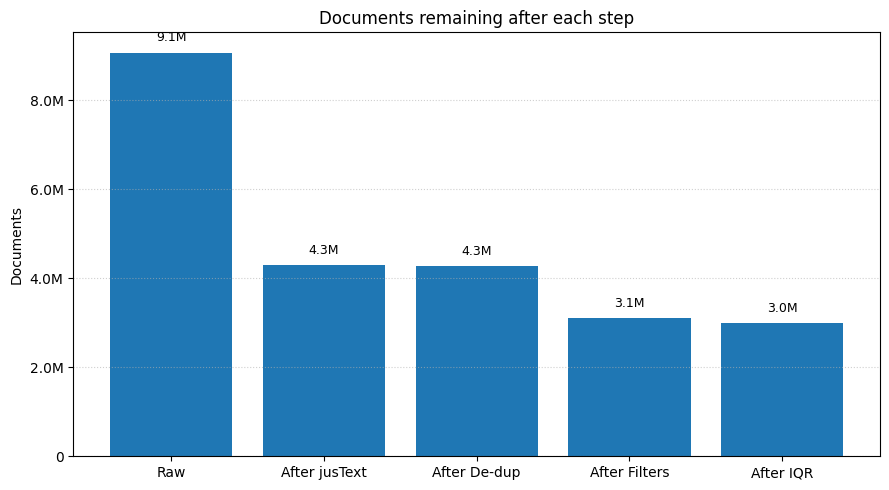

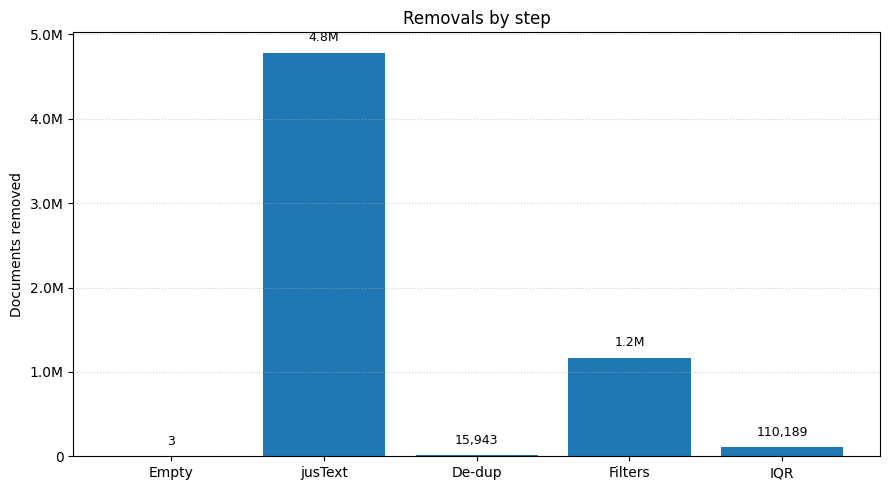

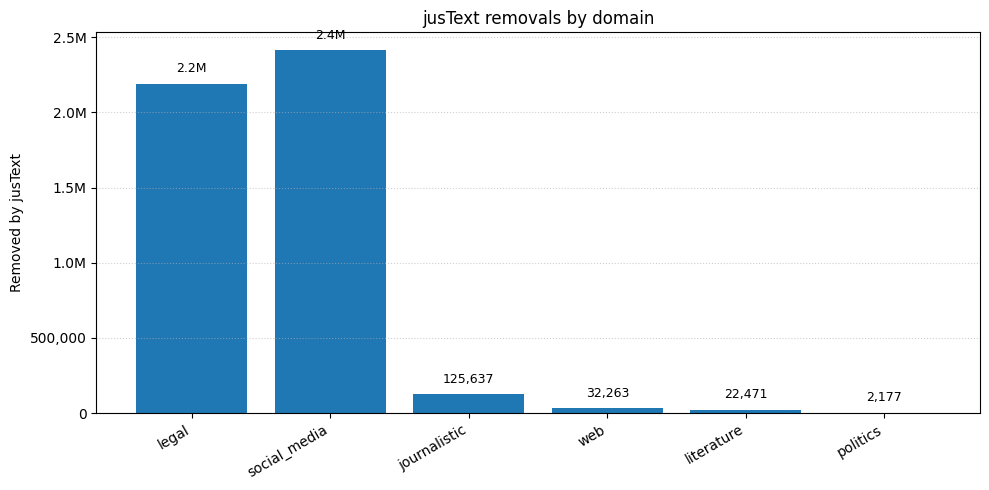

In [ ]:
import duckdb, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

DB_PATH = "../data/duckdb/subs.duckdb"

def _fmt_millions(x, pos):
    return f"{x/1_000_000:.1f}M" if x >= 1_000_000 else f"{int(x):,}"

with duckdb.connect(DB_PATH, read_only=True) as con:
    tot = con.execute("""
      SELECT
        SUM(raw)              AS raw,
        SUM(after_nonempty)   AS after_nonempty,
        SUM(after_jusText)    AS after_jusText,
        SUM(after_dedup)      AS after_dedup,
        SUM(after_filters)    AS after_filters,
        SUM(after_IQR)        AS after_IQR,
        SUM(drop_empty)       AS drop_empty,
        SUM(drop_jusText)     AS drop_jusText,
        SUM(drop_dedup)       AS drop_dedup,
        SUM(drop_filters)     AS drop_filters,
        SUM(drop_IQR)         AS drop_IQR
      FROM ptbrvarid_metrics
      WHERE dataset='PtBrVId'
    """).fetchdf().iloc[0]

# 1) Survivors after each step (like PTradutor’s figure)
survivors = pd.Series({
    "Raw":           int(tot["raw"]),
    "After jusText": int(tot["after_jusText"]),
    "After De-dup":  int(tot["after_dedup"]),
    "After Filters": int(tot["after_filters"]),
    "After IQR":     int(tot["after_IQR"]),
})

plt.figure(figsize=(9,5))
ax = plt.gca()
bars = ax.bar(survivors.index, survivors.values)
ax.set_ylabel("Documents")
ax.set_title("Documents remaining after each step")
ax.yaxis.set_major_formatter(FuncFormatter(_fmt_millions))
ax.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.6)
for b in bars:
    v = b.get_height()
    ax.annotate(_fmt_millions(v, None), xy=(b.get_x()+b.get_width()/2, v),
                xytext=(0, 6), textcoords="offset points", ha="center", va="bottom", fontsize=9)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2) Deletions by step
drops = pd.Series({
    "Empty":    int(tot["drop_empty"]),
    "jusText":  int(tot["drop_jusText"]),
    "De-dup":   int(tot["drop_dedup"]),
    "Filters":  int(tot["drop_filters"]),
    "IQR":      int(tot["drop_IQR"]),
})

plt.figure(figsize=(9,5))
ax = plt.gca()
bars = ax.bar(drops.index, drops.values)
ax.set_ylabel("Documents removed")
ax.set_title("Removals by step")
ax.yaxis.set_major_formatter(FuncFormatter(_fmt_millions))
ax.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.6)
for b in bars:
    v = b.get_height()
    ax.annotate(_fmt_millions(v, None), xy=(b.get_x()+b.get_width()/2, v),
                xytext=(0, 6), textcoords="offset points", ha="center", va="bottom", fontsize=9)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 3) (Optional) Per-domain view of jusText’s impact
with duckdb.connect(DB_PATH, read_only=True) as con:
    dom = con.execute("""
      SELECT domain,
             SUM(after_nonempty) AS nonempty,
             SUM(after_jusText)  AS after_jt,
             SUM(drop_jusText)   AS drop_jt
      FROM ptbrvarid_metrics
      WHERE dataset='PtBrVId'
      GROUP BY domain
      ORDER BY nonempty DESC
    """).fetchdf()

plt.figure(figsize=(10,5))
ax = plt.gca()
bars = ax.bar(dom["domain"], dom["drop_jt"])
ax.set_ylabel("Removed by jusText")
ax.set_title("jusText removals by domain")
ax.yaxis.set_major_formatter(FuncFormatter(_fmt_millions))
ax.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.6)
for b, label in zip(bars, dom["drop_jt"]):
    ax.annotate(_fmt_millions(int(label), None), xy=(b.get_x()+b.get_width()/2, b.get_height()),
                xytext=(0, 6), textcoords="offset points", ha="center", va="bottom", fontsize=9)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [7]:
import duckdb, pandas as pd

con = duckdb.connect(DB_PATH, read_only=True)
total_rows = con.execute("""
-- Exact total (processed only)
SELECT COUNT(*) AS n
FROM ptbrvarid
WHERE dataset = 'PtBrVId';

    """).fetchdf()
                             
total_rows

,n
0,2991728


In [ ]:
import os, nltk, pathlib

# 1) Pick a single directory and make NLTK look there
NLTK_USER_DIR = os.path.expanduser("~/nltk_data")
os.environ["NLTK_DATA"] = NLTK_USER_DIR  # ensure child processes see it too
if NLTK_USER_DIR not in nltk.data.path:
    nltk.data.path.insert(0, NLTK_USER_DIR)

# 2) Force-reinstall punkt + punkt_tab into that directory
nltk.download("punkt", download_dir=NLTK_USER_DIR, force=True, quiet=False)
# Newer NLTK also needs this metadata package
try:
    nltk.download("punkt_tab", download_dir=NLTK_USER_DIR, force=True, quiet=False)
except Exception:
    pass  # older NLTK won't have it

# 3) Verify both the PACKAGE and the Portuguese model are visible
print("NLTK paths:", nltk.data.path)
print("Has package dir? ", pathlib.Path(NLTK_USER_DIR, "tokenizers", "punkt").exists())
nltk.data.find("tokenizers/punkt")                       # should NOT raise
nltk.data.find("tokenizers/punkt/portuguese.pickle")     # should NOT raise

# Quick smoke test
from nltk import word_tokenize
print(word_tokenize("Olá mundo! Isto é um teste.", language="portuguese"))



[nltk_data] Downloading package punkt to
[nltk_data]     /home/laiarodrigo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/laiarodrigo/nltk_data...


NLTK paths: ['/home/laiarodrigo/nltk_data', '/home/laiarodrigo/repos/Thesis/thesis/nltk_data', '/home/laiarodrigo/repos/Thesis/thesis/share/nltk_data', '/home/laiarodrigo/repos/Thesis/thesis/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']
Has package dir?  True
['Olá', 'mundo', '!', 'Isto', 'é', 'um', 'teste', '.']


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


**//PUT ALL PROCESSED DOMAINS AND SPLITS INTO PTBRVARID TABLE AND THEN TO TRAIN AND TEST DATA TABLES**

In [ ]:
# populate_ptbrvarid_full_fixed.py
# ------------------------------------------------------------
# Fully (re)populate DuckDB table `ptbrvarid` from PtBrVId-Raw.
# Requires: clean_one_domain_split(domain, split, ...)
# ------------------------------------------------------------

from datasets import get_dataset_config_names, get_dataset_split_names
import duckdb
import pandas as pd

# ----- label helpers & schema -----

def _label_to_name(ds, val):
    """Map int/str label to a readable name using HF features when available."""
    if isinstance(val, str):
        return val
    try:
        names = ds.features["label"].names
        if isinstance(val, int) and 0 <= val < len(names):
            return names[val]
    except Exception:
        pass
    return str(val)

def _is_pt_br(lbl_name: str, raw_label) -> bool:
    """
    Decide BR vs PT by normalized name; fallback to your rule:
    label 0 == pt-PT (European) → everything else BR.
    """
    s = (lbl_name or "").strip().lower().replace("_", "-")
    if s in {"pt-br", "br", "ptbr", "brazil", "brazilian"}:
        return True
    if s in {"pt-pt", "pt", "eu", "european"}:
        return False
    return (isinstance(raw_label, int) and raw_label != 0)

def _ensure_ptbrvarid_schema(con: duckdb.DuckDBPyConnection):
    # Create table if missing (6-column layout)
    con.execute("""
        CREATE TABLE IF NOT EXISTS ptbrvarid (
            dataset     TEXT,
            domain      TEXT,
            split       TEXT,
            label       TEXT,
            text_pt_br  TEXT,
            text_pt_pt  TEXT
        )
    """)
    # If the table already existed without `domain`, add it.
    cols = [r[1] for r in con.execute("PRAGMA table_info('ptbrvarid')").fetchall()]
    if "domain" not in cols:
        con.execute("ALTER TABLE ptbrvarid ADD COLUMN domain TEXT")
        print("[MIGRATE] Added missing column: domain")

# ----- main ingest -----

def ingest_ptbrvarid_all_to_duckdb(
    db_path: str,
    *,
    keep_accents: bool = True,
    num_proc: int = 1,
    batch_size_hf: int = 1000,
    batch_size_db: int = 5000,
):
    """
    Clears ptbrvarid and fully repopulates it with all cleaned rows.
    Prints progress per split, per domain, and final totals.
    """
    domains = get_dataset_config_names("liaad/PtBrVId-Raw")

    with duckdb.connect(db_path) as con:
        _ensure_ptbrvarid_schema(con)

        # wipe existing contents so this is the ONLY data in the table
        try:
            existing = con.execute("SELECT COUNT(*) FROM ptbrvarid").fetchone()[0]
        except duckdb.CatalogException:
            existing = 0
        con.execute("DELETE FROM ptbrvarid")
        print(f"[RESET] Cleared {existing} old rows from ptbrvarid")

        grand_total = 0

        for domain in domains:
            splits = get_dataset_split_names("liaad/PtBrVId-Raw", domain)
            domain_total = 0
            print(f"\n[DOMAIN] {domain} – {len(splits)} splits")

            for split in splits:
                print(f"  [CLEAN] {domain}/{split} …")
                ds = clean_one_domain_split(
                    domain, split,
                    keep_accents=keep_accents,
                    num_proc=num_proc,
                    batch_size=batch_size_hf,
                )

                buf, n = [], 0
                for ex in ds.to_iterable_dataset():
                    lbl_name = _label_to_name(ds, ex["label"])
                    text = ex["text"]
                    buf.append({
                        "dataset": "PtBrVarId",
                        "domain": domain,
                        "split": split,
                        "label": lbl_name,
                        "text_pt_br": text if _is_pt_br(lbl_name, ex["label"]) else None,
                        "text_pt_pt": text if not _is_pt_br(lbl_name, ex["label"]) else None,
                    })

                    if len(buf) >= batch_size_db:
                        df = pd.DataFrame(buf)
                        con.register("ptbr_buf", df)
                        # INSERT with explicit column list to avoid order mismatches
                        con.execute("""
                            INSERT INTO ptbrvarid (dataset, domain, split, label, text_pt_br, text_pt_pt)
                            SELECT dataset, domain, split, label, text_pt_br, text_pt_pt FROM ptbr_buf
                        """)
                        con.unregister("ptbr_buf")
                        n += len(buf)
                        buf = []

                if buf:
                    df = pd.DataFrame(buf)
                    con.register("ptbr_buf", df)
                    con.execute("""
                        INSERT INTO ptbrvarid (dataset, domain, split, label, text_pt_br, text_pt_pt)
                        SELECT dataset, domain, split, label, text_pt_br, text_pt_pt FROM ptbr_buf
                    """)
                    con.unregister("ptbr_buf")
                    n += len(buf)

                domain_total += n
                grand_total += n
                print(f"  [OK] {domain}/{split}: wrote {n:,} rows")

            print(f"[DOMAIN DONE] {domain}: wrote {domain_total:,} rows across {len(splits)} splits")

        final_count = con.execute("SELECT COUNT(*) FROM ptbrvarid").fetchone()[0]
        print(f"\n[ALL DONE] Inserted {grand_total:,} rows total. Table now has {final_count:,} rows.")

# ----- example usage -----
DB_PATH = "../data/duckdb/subs.duckdb"   # <-- your file
ingest_ptbrvarid_all_to_duckdb(DB_PATH, keep_accents=True, num_proc=1, batch_size_hf=1000, batch_size_db=5000)


[RESET] Cleared 0 old rows from ptbrvarid

[DOMAIN] journalistic – 1 splits
  [CLEAN] journalistic/train …


Map:   0%|          | 0/1842804 [00:00<?, ? examples/s]

Map:   0%|          | 0/1842804 [00:00<?, ? examples/s]

Map:   0%|          | 0/1842804 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1842804 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1842746 [00:00<?, ? examples/s]

Map:   0%|          | 0/1720715 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1720715 [00:00<?, ? examples/s]

  [OK] journalistic/train: wrote 1,687,188 rows
[DOMAIN DONE] journalistic: wrote 1,687,188 rows across 1 splits

[DOMAIN] legal – 1 splits
  [CLEAN] legal/train …


Filter:   0%|          | 0/4302003 [00:00<?, ? examples/s]

Map:   0%|          | 0/4302002 [00:00<?, ? examples/s]

/tmp/ipykernel_3527/3949769824.py:92: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(text, "html.parser")


Map:   0%|          | 0/4302002 [00:00<?, ? examples/s]

Map:   0%|          | 0/4302002 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4302002 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4208238 [00:00<?, ? examples/s]

Map:   0%|          | 0/2781134 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2781134 [00:00<?, ? examples/s]

  [OK] legal/train: wrote 2,664,121 rows
[DOMAIN DONE] legal: wrote 2,664,121 rows across 1 splits

[DOMAIN] literature – 1 splits
  [CLEAN] literature/train …


Filter:   0%|          | 0/81984 [00:00<?, ? examples/s]

Map:   0%|          | 0/81984 [00:00<?, ? examples/s]

Map:   0%|          | 0/81984 [00:00<?, ? examples/s]

Map:   0%|          | 0/81984 [00:00<?, ? examples/s]

Filter:   0%|          | 0/81984 [00:00<?, ? examples/s]

Filter:   0%|          | 0/81981 [00:00<?, ? examples/s]

Map:   0%|          | 0/57002 [00:00<?, ? examples/s]

Filter:   0%|          | 0/57002 [00:00<?, ? examples/s]

  [OK] literature/train: wrote 55,506 rows
[DOMAIN DONE] literature: wrote 55,506 rows across 1 splits

[DOMAIN] politics – 1 splits
  [CLEAN] politics/train …


Filter:   0%|          | 0/34605 [00:00<?, ? examples/s]

Map:   0%|          | 0/34604 [00:00<?, ? examples/s]

Map:   0%|          | 0/34604 [00:00<?, ? examples/s]

Map:   0%|          | 0/34604 [00:00<?, ? examples/s]

Filter:   0%|          | 0/34604 [00:00<?, ? examples/s]

Filter:   0%|          | 0/34603 [00:00<?, ? examples/s]

Map:   0%|          | 0/26444 [00:00<?, ? examples/s]

Filter:   0%|          | 0/26444 [00:00<?, ? examples/s]

  [OK] politics/train: wrote 24,838 rows
[DOMAIN DONE] politics: wrote 24,838 rows across 1 splits

[DOMAIN] social_media – 1 splits
  [CLEAN] social_media/train …


Filter:   0%|          | 0/2678580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2678579 [00:00<?, ? examples/s]

Map:   0%|          | 0/2678579 [00:00<?, ? examples/s]

Map:   0%|          | 0/2678579 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2678579 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2487475 [00:00<?, ? examples/s]

Map:   0%|          | 0/2173248 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2173248 [00:00<?, ? examples/s]

  [OK] social_media/train: wrote 1,993,190 rows
[DOMAIN DONE] social_media: wrote 1,993,190 rows across 1 splits

[DOMAIN] web – 1 splits
  [CLEAN] web/train …


Filter:   0%|          | 0/133664 [00:00<?, ? examples/s]

Map:   0%|          | 0/133664 [00:00<?, ? examples/s]

Map:   0%|          | 0/133664 [00:00<?, ? examples/s]

Map:   0%|          | 0/133664 [00:00<?, ? examples/s]

Map:   0%|          | 0/133664 [00:00<?, ? examples/s]

Filter:   0%|          | 0/133664 [00:00<?, ? examples/s]

Filter:   0%|          | 0/133552 [00:00<?, ? examples/s]

Map:   0%|          | 0/27969 [00:00<?, ? examples/s]

Filter:   0%|          | 0/27969 [00:00<?, ? examples/s]

  [OK] web/train: wrote 25,829 rows
[DOMAIN DONE] web: wrote 25,829 rows across 1 splits

[ALL DONE] Inserted 6,450,672 rows total. Table now has 6,450,672 rows.


In [ ]:
con = duckdb.connect('../data/duckdb/subs.duckdb')
con.execute('SELECT * FROM ptbrvarid WHERE dataset=\'PtBrVId\' LIMIT 50000').df()
con.execute('SELECT COUNT(*) FROM ptbrvarid WHERE dataset=\'PtBrVId\'').fetchone()

,dataset,split,label,text_pt_br,text_pt_pt,domain
0,PtBrVId,journalistic,train,pt-PT,None,"Cardoso e Cunha ""Insatisfatório"" O resultado do referendo francês é insatisfatório, tímido e modesto. Os problemas da Comunidade Europeia exigiam, da parte ..."
1,PtBrVId,journalistic,train,pt-PT,None,"Santo Tirso de fora Apesar da intenção das principais autarquias do Ave, para já Santo Tirso quer ficar de fora deste processo. Joaquim Couto, o presidente ..."
2,PtBrVId,journalistic,train,pt-PT,None,"""1 Rpm"" é a abreviatura para ""Uma Revolução por Minuto"", e a respectiva tradução inglesa, uma vez que os LX-90 de Rui Pregal da Cunha e Pedro Paulo Gonçalve..."
3,PtBrVId,journalistic,train,pt-PT,None,"Luís António Mendes Nobre pode, em Outubro, por alturada 5ª edição do Festival Internacional de Música de Macau, concretizar, como confessou, ""um velho sonh..."
4,PtBrVId,journalistic,train,pt-PT,None,Não posso dizer mais nada. Por que é que me está a fazer perguntas sobre Lisboa? Porque foi presidente da Câmara durante dez anos e nota-se que foi uma fase...
...,...,...,...,...,...,...
49995,PtBrVId,journalistic,train,pt-PT,None,"A vítima, de 32 anos, era conhecida no local como alcoólica: O relatório da PJ salienta que o casal vivia em ""condições miseráveis"". O juiz de instrução cri..."
49996,PtBrVId,journalistic,train,pt-PT,None,"O desafio começou com ajustamentos mútuos, sendo patente a vantagem dos azuis de Belém, graças à supremacia revelada pelo seu sector intermediário. Mauro Ai..."
49997,PtBrVId,journalistic,train,pt-BR,"Suspeito que os maiores interessados em manter a semi-clandestinidade são, justamente, os delinquentes inclusive na polícia, beneficiados por propinas. A hi...",None
49998,PtBrVId,journalistic,train,pt-PT,None,"Eleições vão custar 180 mil contos O ministro da Administração Interna, Manuel Pereira, revelou ontem que os preparativos para as próximas eleições legislat..."


In [ ]:
import duckdb, pathlib, pandas as pd
pd.set_option("display.max_colwidth", 140)

con = duckdb.connect("../data/duckdb/subs.duckdb")

# Known domain names to distinguish real domain vs misplaced text
KNOWN_DOMAINS = ("journalistic","legal","web","literature","politics","social_media")

con.execute("DROP VIEW IF EXISTS ptbrvid_repaired_v;")
con.execute(f"""
CREATE VIEW ptbrvid_repaired_v AS
WITH raw AS (
  SELECT dataset, domain, split, label, text_pt_br, text_pt_pt
  FROM ptbrvarid
  WHERE dataset='PtBrVId'
),
norm AS (
  SELECT
    -- language: prefer explicit label if present, else take the literal that was stuffed into text_pt_br
    CASE
      WHEN lower(label) IN ('pt-br','pt-pt') THEN CASE WHEN lower(label)='pt-br' THEN 'pt-BR' ELSE 'pt-PT' END
      WHEN text_pt_br IN ('pt-BR','pt-PT')      THEN text_pt_br
      ELSE NULL
    END AS lang,

    -- text: prefer the proper text columns; if empty, fall back to `domain` only if it looks like text
    CASE
      WHEN text_pt_br IS NOT NULL AND text_pt_br NOT IN ('pt-BR','pt-PT') THEN text_pt_br
      WHEN text_pt_pt IS NOT NULL AND text_pt_pt NOT IN ('pt-BR','pt-PT') THEN text_pt_pt
      WHEN domain IS NOT NULL AND lower(domain) NOT IN {KNOWN_DOMAINS}
           AND length(domain) > 40 THEN domain
      ELSE NULL
    END AS text,

    split, domain
  FROM raw
),
ok AS (
  SELECT
    'PtBrVId' AS dataset,
    split,
    lang  AS label,
    CASE WHEN lang='pt-BR' THEN text END AS text_pt_br,
    CASE WHEN lang='pt-PT' THEN text END AS text_pt_pt
  FROM norm
  WHERE lang IS NOT NULL AND text IS NOT NULL
)
SELECT * FROM ok;
""")


In [ ]:
display(con.execute("""
SELECT split, label, text_pt_br, text_pt_pt
FROM ptbrvid_repaired_v
ORDER BY random()
LIMIT 10
""").df())


,split,label,text_pt_br,text_pt_pt
0,legal,pt-PT,None,"Porém, atente-se nesta parte do Sumário: - O princípio do in dubio pro reo constitui uma imposição dirigida ao julgador no sentido de se..."
1,legal,pt-PT,None,"Concluíram requerendo que ""se considere justificada a não entregados valores indicados, requerendo ainda o aumento do valor disponível m..."
2,legal,pt-PT,None,"O contrato de locação financeira apresenta uma estrutura bilateral, onde são realizados dois contratos: O fornecedor celebra um contrato..."
3,journalistic,pt-PT,None,"""Sobre a terra, um ligeiro aguaceiro e um arco-íris completo envolvendo a histórica Torre de Belém, como numa auréola de glória. Vemos a..."
4,social_media,pt-PT,None,"Discorda à vontade, porque nitidamente não fazes a mínima ideia sobre o que estás a falar. Desenvolvimento? Zero. Suporte? Zero. Trata-s..."
5,journalistic,pt-PT,None,"No Cinearte, em Santos, há música improvisada a partir da 1h00. Eduardo Cunha e João Oliveira, nas guitarras eléctricas e Luis Desirat, ..."
6,journalistic,pt-BR,"Outra alteração é o ""sugar craving"" (desejo exagerado de comer açúcar). ""É uma compulsão. As pessoas não têm domínio sobre a situação"", ...",None
7,legal,pt-PT,None,Que foi o arguido quem levou a cabo a agressão de que resultaram as lesões e morte da sua mãe nas circunstâncias mencionadas nos factos ...
8,journalistic,pt-PT,None,"De resto, as propostas de Schaeuble são olhadas, aqui, como um primeiro balão de ensaio às posições que a Alemanha defenderá na Conferên..."
9,social_media,pt-PT,None,"APELO À AUTARQUIA DE ANADIA! Muitos de nós abdicam, como eu, de receber salário para poder pagar salários dos funcionários e contas à au..."


**//FRMT DATASET**

In [ ]:
GITHUB_RAW = ("https://raw.githubusercontent.com/google-research/google-research/"
              "HEAD/frmt/dataset")

buckets = {          # bucket → filename prefix inside that bucket
    "lexical": "pt_lexical",
    "entity" : "pt_entity",
    "random" : "pt_random",
}

splits   = ["dev", "test", "exemplars"]        # the paper’s three splits
regions  = ["pt-BR", "pt-PT"]                  # ⬅️ we ignore zh-* files

def urls(bucket):
    prefix = buckets[bucket]
    return [f"{GITHUB_RAW}/{bucket}_bucket/"
            f"{prefix}_{split}_en_{region}.tsv"
            for split in splits
            for region in regions]

# sanity-check
print(urls("entity")[:3])


['https://raw.githubusercontent.com/google-research/google-research/HEAD/frmt/dataset/entity_bucket/pt_entity_dev_en_pt-BR.tsv', 'https://raw.githubusercontent.com/google-research/google-research/HEAD/frmt/dataset/entity_bucket/pt_entity_dev_en_pt-PT.tsv', 'https://raw.githubusercontent.com/google-research/google-research/HEAD/frmt/dataset/entity_bucket/pt_entity_test_en_pt-BR.tsv']


In [ ]:
def split_key(bucket, split, region):
    # pt-BR  ➜  pt_BR   (dash → underscore)
    return f"{bucket}_{split}_{region.replace('-', '_')}"

data_files = {
    split_key(bucket, split, region): [
        f"{GITHUB_RAW}/{bucket}_bucket/"
        f"{buckets[bucket]}_{split}_en_{region}.tsv"
    ]
    for bucket in buckets
    for split  in splits
    for region in regions
}

from datasets import load_dataset, DatasetDict

ds = load_dataset(
        "csv",
        data_files   = data_files,
        delimiter    = "\t",
        column_names = ["en", "pt"],
)

print(list(ds.keys())[:6])
# ['lexical_dev_pt_BR', 'lexical_dev_pt_PT', 'lexical_test_pt_BR', …]


['lexical_dev_pt_BR', 'lexical_dev_pt_PT', 'lexical_test_pt_BR', 'lexical_test_pt_PT', 'lexical_exemplars_pt_BR', 'lexical_exemplars_pt_PT']


In [ ]:
entity_br = pd.DataFrame(ds['entity_dev_pt_BR'])

In [ ]:
entity_br

,en,pt
0,"Constâncio was Secretary of State for Planning in the I and II Provisional Government of Portugal from 1974 to 1975, and Secretary of State for Budget and Planning in 1976 in the IV Provisional Government.","Constâncio foi Secretário de Estado para Planejamento no 1º e 2º Governos Provisórios de Portugal, de 1974 a 1975, e Secretário de Estado para Orçamento e Planejamento em 1976 no 4º Governo Provisório."
1,"He then became Finance Minister from January to August 1978 in the II Constitutional Government of Portugal, and is therefore until now the youngest Portuguese Finance Minister since the revolution.","Depois, tornou-se Ministro das Finanças de janeiro a agosto de 1978 no 2º Governo Constitucional de Portugal, e é, portanto, até hoje, o Ministro das Finanças português mais jovem desde a revolução."
2,Constâncio was secretary-general of the Socialist Party from 1986 to 1989.,"De 1986 a 1989, Constâncio foi secretário-geral do Partido Socialista."
3,"He lost the legislative elections of 19 July 1987, but remained in office.","Ele perdeu as eleições legislativas de 19 de julho de 1987, mas permaneceu no gabinete."
4,"He resigned the following year, being replaced by Jorge Sampaio.","No ano seguinte, ele renunciou, sendo substituído por Jorge Sampaio."
...,...,...
930,"The northern and western sides of the castle, on the other hand, were naturally protected by the steep hillside sloping downward from the castle's foundations.","Os lados norte e oeste do castelo, por sua vez, eram naturalmente protegidos pela colina íngreme inclinada para baixo das fundações do castelo."
931,"The castle is also partially encircled by a moat, now dry.","O castelo também é, em parte, rodeado por um fosso, agora seco."
932,The main entrance is fronted by a stone bridge across the moat.,"De frente para a entrada principal, há uma ponte de pedra sobre o fosso."
933,"On the west side, there is a long curtain wall extending downhill, ending at a tower (the Torre De Couraça).","No lado oeste, há uma divisória que se estende para baixo, terminando em uma torre (a Torre de Couraça)."


In [ ]:
entity_pt = pd.DataFrame(ds['entity_dev_pt_PT'])
entity_pt[entity_pt["en"].duplicated(keep=False)].head()

,en,pt
52,"After the Portuguese legislative election of 2009, held on 27 September 2009, José Sócrates was elected for a second term as Prime Minister of Portugal.","Após as eleições legislativas portuguesas de 2009, realizadas em 27 de setembro de 2009, José Sócrates foi eleito pela segunda vez Primeiro-Ministro de Portugal."
64,"After the Portuguese legislative election of 2009, held on 27 September 2009, José Sócrates was elected for a second term as Prime Minister of Portugal.","Após as eleições legislativas portuguesas de 2009, realizadas em 27 de setembro de 2009, José Sócrates foi eleito para um segundo mandato como Primeiro-Ministro de Portugal."


In [ ]:
entity_br[entity_br["en"].duplicated(keep=False)].head()

,en,pt
52,"After the Portuguese legislative election of 2009, held on 27 September 2009, José Sócrates was elected for a second term as Prime Minister of Portugal.","Após a eleição legislativa portuguesa de 2009, realizada em 27 de setembro de 2009, José Sócrates foi eleito para um segundo mandato como primeiro-ministro de Portugal."
64,"After the Portuguese legislative election of 2009, held on 27 September 2009, José Sócrates was elected for a second term as Prime Minister of Portugal.","Após a eleição legislativa portuguesa de 2009, realizada em 27 de setembro de 2009, José Sócrates foi eleito para um segundo mandato como primeiro-ministro de Portugal."


**//GOLD COLLECTION**

In [ ]:
ds = load_dataset("joaosanches/golden_collection")

ds


DatasetDict({
    gold_collection: Dataset({
        features: ['text'],
        num_rows: 500
    })
    referencia_DeepL: Dataset({
        features: ['text'],
        num_rows: 500
    })
    referencia_manual: Dataset({
        features: ['text'],
        num_rows: 500
    })
})

In [ ]:
pd.DataFrame(ds['gold_collection'])

,text
0,"Segundo Kellner, apesar de o animal ser um baixinho (poderia atingir, no máximo, 2,5 metros de altura), suas patas e bacia têm características anatômicas muito semelhantes às do ilustre réptil norte-americano.\n"
1,"Para a ONG, há evidências de que as companhias que mais exportam madeira para os EUA estejam envolvidas com o comércio ilegal do produto.\n"
2,"Mas, segundo a agência de notícias France Presse, a Venezuela já tem um caso suspeito: um homem de 48 anos que viajou recentemente à China.\n"
3,Ele afirmou que dieta e exercícios devem continuar a protagonizar tratamentos para emagrecer.\n
4,"O biólogo William Eberhard, da Universidade da Costa Rica, descobriu que as larvas desse inseto, ao parasitar a aranha Plesiometa argyra, provocam mudanças no comportamento da hospedeira.\n"
...,...
495,"Isso significa que a preposição é o termo que relaciona substantivo a substantivo, verbo a substantivo, substantivo a verbo, adjetivo a substantivo, advérbio a substantivo, etc.\n"
496,Foi então que a vestimenta mais feminina que se conhece começou a ganhar forma: o espartilho.\n
497,Um de seus professores foi Martin Wegelius.\n
498,"Nessa época, iniciou uma verdadeira polêmica com o escritor democrata Björnstjerne Björnson, através de correspondência.\n"


In [ ]:
pd.DataFrame(ds['referencia_manual'])

,text
0,"Segundo Kellner, apesar de o animal ser muito pequeno (poderia atingir, no máximo, 2,5 metros de altura), as suas patas e bacia têm características anatómicas muito semelhantes às do ilustre réptil norte-americano.\n"
1,"Para a ONG, há evidências de que as empresas que mais exportam madeira para os EUA estejam envolvidas com o comércio ilegal do produto.\n"
2,"Mas, segundo a agência de notícias France Presse, a Venezuela já tem um caso suspeito: um homem de 48 anos que viajou recentemente à China.\n"
3,Ele afirmou que dieta e exercícios devem continuar a protagonizar tratamentos para emagrecer.\n
4,"O biólogo William Eberhard, da Universidade da Costa Rica, descobriu que as larvas desse inseto, ao parasitar a aranha Plesiometa argyra, provocam mudanças no comportamento da hospedeira.\n"
...,...
495,"Isso significa que a preposição é o termo que relaciona substantivo a substantivo, verbo a substantivo, substantivo a verbo, adjetivo a substantivo, advérbio a substantivo, etc.\n"
496,Foi então que a peça de vestuário mais feminina que se conhece começou a ganhar forma: o espartilho.\n
497,Um dos seus professores foi Martin Wegelius.\n
498,"Nessa época, iniciou-se uma verdadeira polémica com o escritor democrata Björnstjerne Björnson, através de correspondência.\n"
